<a href="https://colab.research.google.com/github/SimoneCallegarin/NLP_project/blob/main/SA_and_TextGen_on_EDOS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Environment Setup**

## **Libraries Imports**

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from sklearn.cluster import KMeans
from sklearn import metrics

## **Dataset Download**

In [2]:
csv_path = "https://media.githubusercontent.com/media/SimoneCallegarin/NLP_project/main/EDOS_1M.csv"

# **Dataset Import and Cleaning**

We will now import the EDOS dataset and clean it from:
    
- duplicates
- null values

In [3]:
df = pd.read_csv(csv_path)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2829426 entries, 0 to 2829425
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   dialogue_id       int64  
 1   turn              int64  
 2   uttr              object 
 3   eb+_emot          object 
 4   label_confidence  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 107.9+ MB


In [5]:
df.head()

,dialogue_id,turn,uttr,eb+_emot,label_confidence
0,97,1,You moron ! What fool washes diapers by the we...,angry,0.437522
1,97,2,You useless fool !,furious,0.731564
2,99,1,How dare you sleep !,furious,0.605636
3,99,2,Up ! Go and clean the house .,prepared,0.650449
4,100,1,Clean the kitchen .,prepared,0.742187


In [ ]:
df.duplicated().sum()

0

In [ ]:
def isEnglish(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return None
    else:
        return s

In [ ]:
df['uttr'].apply(lambda s: isEnglish(s)).size  #same size as before, no rows were removed 

As we can see the dataset was already cleaned since we have no duplicated, null rows or not-ASCII characters (which usually means we are dealing with a multilingual dataset), so we can proceed to the next steps without worries.

# **Preliminary Analysis**

## **EDA - Exploratory Data Analysis**

Before diving into the training and evaluation of many different NLP models, we will perform the EDA (Exploratory Data Analysis) to have basic but fundamental insights about the data.

In particular we will get:

- basic informations about the dataset
- some descriptive statistics

### **Basic Understanding of the Dataset**

As stated on the dataset website, EDOS contains short phrases (from 3 to 5 utterances), each labeled with an emotion. Let's get a better look at them

In [ ]:
print([x for x in df['uttr'][0:5]])

['You moron ! What fool washes diapers by the well !', 'You useless fool !', 'How dare you sleep !', 'Up ! Go and clean the house .', 'Clean the kitchen .']


Let's now check all the possible values of the emotion type, which will be our target in case of sentiment analysis

In [ ]:
df['eb+_emot'].unique()

array(['angry', 'furious', 'prepared', 'acknowledging', 'trusting',
       'confident', 'hopeful', 'caring', 'sentimental', 'anticipating',
       'wishing', 'surprised', 'ashamed', 'questioning', 'sad',
       'nostalgic', 'devastated', 'terrified', 'embarrassed', 'lonely',
       'encouraging', 'suggesting', 'content', 'afraid', 'impressed',
       'agreeing', 'apprehensive', 'proud', 'annoyed', 'anxious',
       'grateful', 'excited', 'neutral', 'faithful', 'guilty',
       'consoling', 'disgusted', 'disappointed', 'jealous', 'joyful',
       'sympathizing'], dtype=object)

With all these possible emotions to predict, it's very probable that we will have to deal with unbalanced classes

<AxesSubplot: >

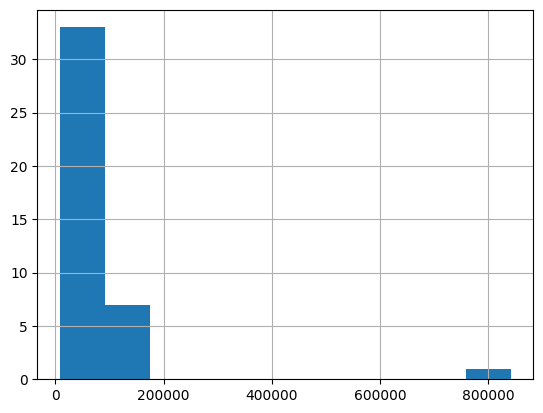

In [ ]:
df['eb+_emot'].value_counts().hist()

In [ ]:
df['eb+_emot'].value_counts()[:5]

questioning      841556
furious          169917
acknowledging    138165
trusting         134197
wishing          108668
Name: eb+_emot, dtype: int64

As we can see, we have quite an unbalancing here with the 'questioning' texts being over 800k while all the others stay under 200k.

We will have to deal with it in the next phases when we will have to train models on this dataset

### **Descriptive Statistics**

We will use some text visualization techniques for better and instant insights about:

- text lengths distribution
- word number distribution

<AxesSubplot: >

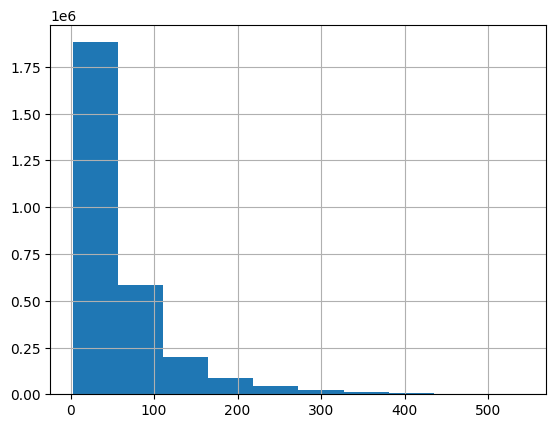

In [ ]:
df['uttr'].str.len().hist()

In [ ]:
def plot_words_number(texts):
    texts.str.split().map(lambda x: len(x)).hist()

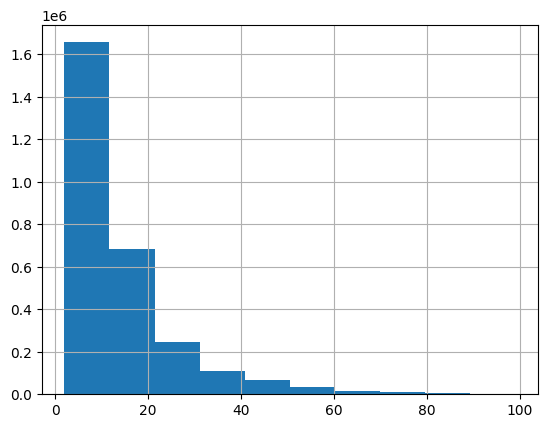

In [ ]:
plot_words_number(df['uttr'])

It's clear that most texts' vocabulary size stays under 20 words, with the most being between 2 and 10.

But we can also see we have pretty long texts too so let's have a look at one of them

In [ ]:
df[(df['uttr'].str.len() > 300)]['uttr'].iloc[0]

"Glenn , why don 't you tell us about the top looks ? Kris , we love the ram look of your makeup , and some of the smaller sculptural details were very impressive . It was a very comprehensive makeup . Wayne , your use of proportion was excellent this week . We were also blown away by how much killer sculpting you pulled off . Who is the winner of this challenge ?"

## **Clustering**

In this section we will apply some clustering techniques to check what groups can be found and if those corresponds, even partially, to our known classes.

### **Vectorization with TF-IDF**

Before diving into clustering, we will have to preprocess our dataset. In particular we will have to vectorize our texts and to do that we will use TF-IDF.

In [ ]:
X = df['uttr']
y = df['eb+_emot']

We will remove numbers since they don't represent any meaningful information in our semantical context and they only enlarge TF-IDF vectors slowing down training and preprocessing steps.

We will remove numbers and stopwords from the corpus, plus words appearing in less than 5 documents or in more than the 80% of the collection (to remove corpus-specific stopwords).

In [ ]:
def preprocess(t):
    return re.sub('[0-9]','',t).lower()

In [ ]:
tfidf_vec = TfidfVectorizer(strip_accents='unicode',
                            stop_words='english',
                            preprocessor=preprocess,
                            lowercase=True,
                            min_df=5,
                            max_df=0.8
                           )

In [ ]:
X = tfidf_vec.fit_transform(X)

In [ ]:
tfidf_vec.get_feature_names_out().size

58130

### **Clustering with K-Means**

In [ ]:
k = len(set(y))

In [ ]:
kmeans = KMeans(n_clusters=k,
                max_iter=100,
                n_init=2,
                verbose=False,
                random_state=2307)
kmeans.fit(X)

In [ ]:
print("Top terms per cluster:")
vocab = tfidf_vec.get_feature_names_out()

for i in range(kmeans.n_clusters):
    centroid = kmeans.cluster_centers_[i]    
    sorted_terms = centroid.argsort()[::-1]
    print(f"Cluster {i}:\t{[vocab[j] for j in sorted_terms[:10]]}")

Top terms per cluster:
Cluster 0:	['come', 'time', 've', 'okay', 'sorry', 'tell', 'really', 'say', 'man', 'stop']
Cluster 1:	['want', 'don', 'know', 'talk', 'come', 'tell', 'sure', 'did', 'really', 'just']
Cluster 2:	['like', 'looks', 'don', 'know', 'feel', 'just', 'really', 've', 'come', 'sounds']
Cluster 3:	['know', 'don', 'does', 'really', 'mean', 'tell', 'just', 've', 'maybe', 'say']
Cluster 4:	['did', 'say', 'come', 'tell', 'know', 'hear', 'happen', 'kill', 'just', 'leave']
Cluster 5:	['need', 'help', 'don', 'know', 'll', 'talk', 'just', 'right', 'think', 'come']
Cluster 6:	['yeah', 'right', 'okay', 'good', 'sure', 'know', 'like', 'did', 'oh', 'll']
Cluster 7:	['sir', 'yes', 'thank', 'good', 'sorry', 'right', 'excuse', 'don', 'come', 'll']
Cluster 8:	['just', 'don', 'know', 'like', 'll', 'little', 'sorry', 'want', 'right', 'okay']
Cluster 9:	['right', 'll', 'okay', 'come', 'know', 'away', 'hey', 'gonna', 'don', 'just']
Cluster 10:	['life', 've', 'know', 'saved', 'don', 'just', 'li

Results don't look very promising. We can see that many words repeat in different clusters like 'come' or 'okay' and this suggests that KMeans algorithm didn't succeed in splitting datapoints into clear, distinct clusters.
But to have a better idea of how KMeans performed in our task, let's compute extrisinc evaluation metrics.

In [ ]:
print('Extrinsic evaluation measures:')
print("Homogeneity:", str(metrics.homogeneity_score(y, kmeans.labels_)))
print("Completeness:", str(metrics.completeness_score(y, kmeans.labels_)))
print("V-measure:", str(metrics.v_measure_score(y, kmeans.labels_)))
print("Adjusted Rand-Index:", str(metrics.adjusted_rand_score(y, kmeans.labels_)))

Extrinsic evaluation measures:
Homogeneity: 0.07606013168824871
Completeness: 0.10419010845321364
V-measure: 0.08793012828548737
Adjusted Rand-Index: 0.009427952268841576


As expected ,results are not very accurate. This could be caused by many different characteristics of our dataset like for example non-spherical clusters or unequal cluster size or density. We probably need a more complex clustering algorithm

### **Clustering with LDA**

KMeans algorithm tries to associate each data point to a single cluster and in our case this may have been one of the reasons of its bad performance. Let's try to generate again the clusters by using Latent Dirichlet Allocation, which will associate each datapoints to a variety of topics (clusters) which could be useful in more complex datasets like ours.

In [ ]:
#TODO

## **Embeddings**

In [ ]:
#TODO

## **Indexing for Keyword Search**

In [ ]:
#TODO

# **Sentiment Analysis**

## **Training and Evaluation with TF-IDF Vectorization**

### **Vectorization with TF-IDF**

In [ ]:
X = df['uttr']
y = df['eb+_emot']

As before (Clustering section) we will preprocess and vectorize the corpus.

In [ ]:
def preprocess(t):
    return re.sub('[0-9]','',t).lower()

In [ ]:
tfidf_vec = TfidfVectorizer(strip_accents='unicode',
                            stop_words='english',
                            preprocessor=preprocess,
                            lowercase=True,
                            min_df=5,
                            max_df=0.8
                           )

In [ ]:
X = tfidf_vec.fit_transform(X)

In [ ]:
tfidf_vec.get_feature_names_out().size

58130

In [ ]:
#Training from scratch ML models, different types of NN and inference/fine-tuning with transformers
#Try TF-IDF and SpaCy Embeddings vectorization and compare performance and training/inference time